# Notebook Content

This notebook contains:<br>
    1. Defining important reusable methods.<br>
    2. Reading data from sql.<br>
    3. Dropping some columns.<br>
    4. Introducing dummies.<br>
    5. Target-Feature relationship plot.<br>
    6. Initial splitting of features & targets.<br>
    7. Splitting training, validation and testing.<br>
    8. Solving the imblanaced classes issue.<br>
    9. Model selection.<br>
    10. Models with polynomial features.<br>
    11. Decision boundry plot for each model.<br>
    12. Introducin the best 3 models to voting/stacked classifier.<br>
    13. Feature engineering attempts on chosen model.<br>
    14. Saving to database.<br>

### Importing needed libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
import sqlite3 as sql
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.classifier import StackingClassifier
from ipywidgets import interactive, FloatSlider
import xgboost as xgb
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures
import imblearn.over_sampling
from sklearn.naive_bayes import BernoulliNB, GaussianNB
import matplotlib.gridspec as gridspec
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA

### Used Methods

Various methods were initialized to be called during the whole process of model selectiion each with a specific purpose.

In [2]:
def get_new_scores(Xs_train_lc, y_train_lc, Xs_val_lc, y_val_lc):
    """
    This method will be called to fit the training set with score and predict the score for validation set.
    After that, it will print all the scores by calling another function to get 
    the accuracy, recall, precision and f1.
    """
    stacked_FE_lc = StackingClassifier(
    classifiers = model_vars, meta_classifier=RandomForestClassifier(n_estimators=100), use_probas=False)
    stacked_FE_lc.fit(Xs_train_lc, y_train_lc)
    y_pred_ss_lc = stacked_FE_lc.predict(Xs_val_lc)
    getScores(stacked_FE_lc, Xs_train_lc, y_train_lc, Xs_val_lc, y_val_lc, y_pred_ss_lc)

In [3]:
def getScores(model_,X_train_, y_train_, X_val_, y_val_, y_pred_):
    """
    This method gets all the needed scores (accuracy, precision, recall and f1) 
    from the training/validation sets after getting the model, x train and
    validation, y train and validation, and the y predicted
    """
    print("Training Score ",model_.score(X_train_, y_train_))
    print("Validation Score ",model_.score(X_val_, y_val_))
    print("Precision: {:6.4f},   Recall: {:6.4f}, f1: {:6.4f}".format(precision_score(y_val_, y_pred_), 
                                                         recall_score(y_val_, y_pred_),f1_score(y_val_,y_pred_)))

In [4]:
def modelEvaluation(model, params, data):
    """
    This method is for fitting and evaluating the model for different parameters
    """
    # Split the data into different training and test set
    X_train, X_test, y_train, y_test = data
    
    # Set the different parameters
    paramlist = []
    for param in params: 
        for val in params[param]:
            var = {}
            var[param] = val
            paramlist.append(var)
    maxauc = 0
    bestmodel = ""
    for param in paramlist:
        
        #Fit the model
        model.set_params(**param)
        model.fit(X_train, y_train)
        
        # Model prediction
        y_pred = model.predict(X_test)
        scores = classification_report(y_test, y_pred)
        y_pred_proba = model.predict_proba(X_test)[::, 1]
        
        # Find fpr, tpr and auc
        fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        
        # Find maximum AUC
        if (auc > maxauc):
            maxauc = auc 
            bestparam = param

        
        # Draw ROC curve
        plt_ = drawROC(fpr, tpr, auc, str(param)) 
        plt_.xlabel("FPR")
        plt_.ylabel("TPR")
        title = type(model).__name__ + " ROC curve"
        plt_.figtext(0.5, 0.01, title, wrap=True, horizontalalignment='center', fontsize=12)
    # print("Best Model: " + bestmodel)
    return (bestparam, plt)

In [5]:
def gridSearch(model, params):
    """
    This method is for finding the best fitted parameters for the given model
    """
    grid = GridSearchCV(model, params, cv=5, scoring='f1')
    grid.fit(X1, y1);
    pd.DataFrame(grid.cv_results_)
    return f'Best params: {grid.best_params_} Best estimator: {grid.best_estimator_} Best score: {grid.best_score_}'

In [6]:
def drawROC(fpr, tpr, auc, param):   
    """
    This method draws the ROC curve for each parameter
    """
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle='--')
    plt.plot(fpr, tpr, label= param+'(AUC = {0:0.4f})'
                   ''.format(auc))
    plt.legend(loc=4)
    return plt

In [7]:
def modelComparision(models, data):
    """
    This method is for comparing each model under the ROC curve
    """
    # Split the data into different training and test set
    X_train, X_test, y_train, y_test = data
    
    maxauc = 0
    for model in models:
        modelName = type(model).__name__ 
        
        #Fit the model        
        model.fit(X_train, y_train)
        
        # Model prediction
        y_pred = model.predict(X_test)
        scores = classification_report(y_test, y_pred)
        y_pred_proba = model.predict_proba(X_test)[::, 1]
        
        # Find fpr, tpr and auc
        fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        
        # Find maximum AUC
        if (auc > maxauc):
            maxauc = auc 
            bestmodel = modelName
            bestscore = scores        

        
        # Draw ROC curve
        
        plt = drawROC(fpr, tpr, auc, modelName) 
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        title = "ROC Comparison"
        plt.figtext(0.5, 0.01, title, wrap=True, horizontalalignment='center', fontsize=12)
    print("Best Model: " + bestmodel)
    return (bestmodel, bestscore, plt)

In [8]:
def make_confusion_matrix(model, threshold=0.5):
    """
    This method draws the confusion matrixs for each given model
    """
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_val)[:, 1] >= threshold)
    avtivity_confusion = confusion_matrix(y_val, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(avtivity_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Stationary', 'Moving'],
           yticklabels=['Stationary', 'Moving']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

### Reading data from SQL

In [9]:
all_data_connection = sql.connect('Data/All_data.db')
all_data = pd.read_sql('SELECT * FROM All_data', all_data_connection)

### Dropping index column

The index column was attached to the dataset from the database.

In [10]:
#drop index column
all_data.drop('index', axis='columns', inplace = True)

In [11]:
all_data.head()

,x,y,z,User,Model,Device,Activity,sensor,Arrival_Time,Arrival_Date,Activity_Class
0,-2.986130,-1.034882,6.559341,d,nexus4,nexus4_2,stairsup,phone_acc,16:02,2015-02-24,1.0
1,-3.675100,0.252588,8.872911,e,s3mini,s3mini_1,stand,phone_acc,17:16,2015-02-24,0.0
2,8.963364,3.074371,1.646408,e,lgwatch,lgwatch_1,stand,watch_acc,17:13,2015-02-24,0.0
3,0.469391,-0.280609,-0.408859,c,nexus4,nexus4_1,bike,phone_gyro,15:43,2015-02-23,1.0
4,0.417099,-0.403702,-1.359741,f,nexus4,nexus4_1,stairsup,phone_gyro,15:22,2015-02-24,1.0


### Converting categorical data to dummies

The columns that needed to be transformed into dummies are:<br>
    -Model.<br>
    -Sensor.<br>

In [12]:
Model_dummies = pd.get_dummies(all_data.Model,drop_first=True)

In [13]:
Sensor_dummies = pd.get_dummies(all_data.sensor,drop_first=True)

### Merging dummies with the original dataset

In [14]:
all_data = pd.concat([all_data,Model_dummies,Sensor_dummies],axis=1)

### Target-Feature relastionship

In [15]:
# Specifiying the columns that are relevent
needed_col = ['x','y','z','lgwatch','nexus4','s3','s3mini','samsungold','phone_gyro','watch_acc','watch_gyro']

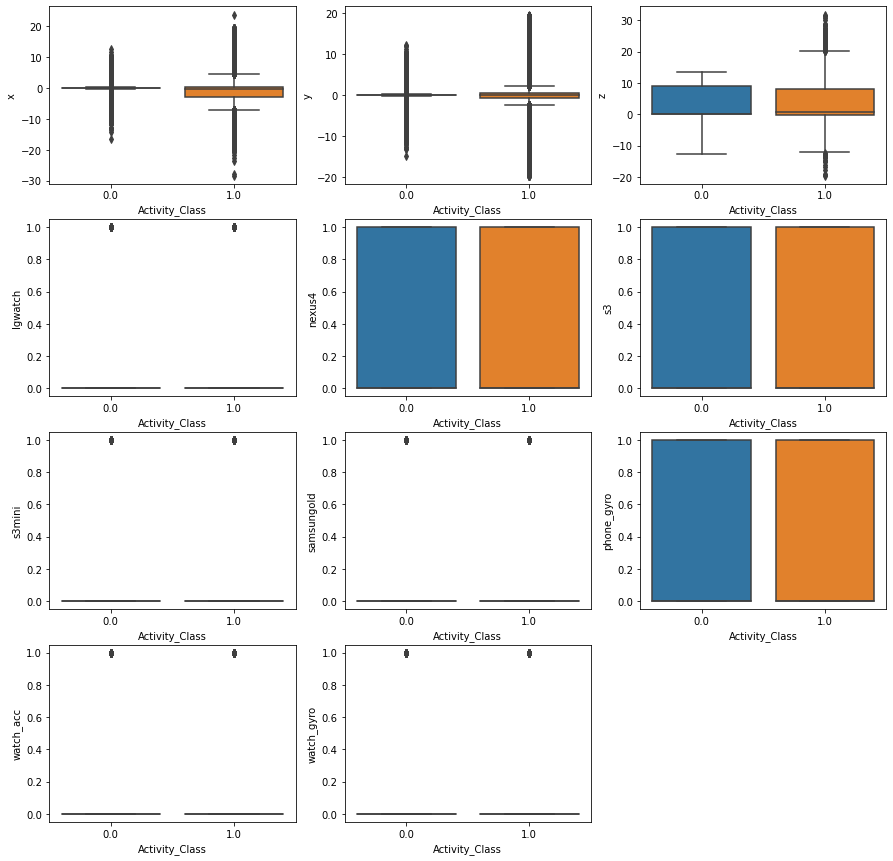

In [17]:
plt.figure(figsize=[15,15])
for i in range(11):
    plt.subplot(4,3,i+1)
    sns.boxplot(x = all_data.Activity_Class, y = all_data[needed_col[i]], data=all_data);

### Initial splitting for features and target

In [16]:
X = all_data[needed_col]
y = all_data.Activity_Class #0,1

The target transformed from 6 classes (stand, walk, sit, bike, stairsup and stairsdown) into  2 classes (stationary and moving)

### Splitting the data into training, validation and testing

Training set **->** 95%<br>
Testing set **->** 2.5%<br>
validation set **->** 2.5%<br>

In [17]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.05, random_state=77)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=77)

Merging the train and validation sets for both x and y for the purpose of refitting into the final model.

In [18]:
X1,y1=pd.concat([X_train,X_val]),pd.concat([y_train,y_val])

### Solving the imbalanced classes issue

#### Oversampling

The dominating class is class 1 which is reasonable since 4 different types of activities were merged all together.
Unlike class 0 which includes 2 types of activites.

In [19]:
y_train.value_counts() # Value count for each class. imbalanced!

1.0    269555
0.0    137482
Name: Activity_Class, dtype: int64

In [20]:
len(all_data)

428460

In [21]:
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
ratio = {1 : n_pos, 0 : n_neg * 2} #doubling the ratio for class 0

ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state = 77)     
X_train, y_train = ROS.fit_resample(X_train, y_train)


/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (274964) in class 0 will be larger than the number of samples in the majority class (class #1.0 -> 269555)
  warnings.warn(


In [22]:
y_train.value_counts() # Value count for each class after oversampling. balanced!

0.0    274964
1.0    269555
Name: Activity_Class, dtype: int64

### Display new subsets shapes

In [23]:
print('X_train  ==> ',X_train.shape)
print('y_train  ==> ',y_train.shape)
print()
print('X_val    ==> ',X_val.shape)
print('y_val    ==> ',y_val.shape)
print()
print('X_test   ==> ',X_test.shape)
print('y_test   ==> ',y_test.shape)

X_train  ==>  (544519, 11)
y_train  ==>  (544519,)

X_val    ==>  (10711, 11)
y_val    ==>  (10711,)

X_test   ==>  (10712, 11)
y_test   ==>  (10712,)


# Model Selection

### 1- Logistic Regression (Baseline)

#### Grid Search to choose best complixcity parameter

In [26]:
Complixity_values = list(range(1, 1000))
param_grid_lr = dict(C=Complixity_values)
gridSearch(LogisticRegression(), param_grid_lr) # Calling the function responsible for grid search

#### Model Fitting

In [24]:
lr = LogisticRegression(C=1, random_state = 77) # Best C value = 1
lr.fit(X_train, y_train)

LogisticRegression(C=1, random_state=77)

#### Model Prediction

In [25]:
y_predict_lr = lr.predict(X_val) 

#### Model Scores

In [26]:
getScores(lr, X_train, y_train, X_val, y_val, y_predict_lr)

Training Score  0.5936946185532552
Validation Score  0.5391653440388385
Precision: 0.7625,   Recall: 0.4399, f1: 0.5579


The **Logistic Regression** performed badly given its just a baseline. It also defines its decision boundires lineary and clearly the dataset is distributed not lineary.


#### Model Confuision Matrix 

In [27]:
interactive(lambda threshold: make_confusion_matrix(lr, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

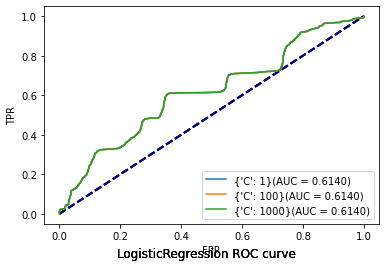

In [84]:
param = {"C": [1, 100, 1000]}
treeparam, treeplt = modelEvaluation(LogisticRegression(), param, [X_train, X_val, y_train, y_val])
treepred = lr.predict(X_val)
treescore = lr.score(X_val, y_val), precision_score(y_val, y_predict_lr), recall_score(y_val, y_predict_lr)

Different values for complexity were tried but all gave the same result.

### 2- Decision Tree Classifier

#### Grid Search to Chose Best max depth

In [32]:
max_depth = list(range(0, 30))
param_grid_decisiontree = dict(max_depth=max_depth)
gridSearch(DecisionTreeClassifier(), param_grid_decisiontree)# Calling the function responsible for grid search

/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 898, in fit
    super().fit(
  File "/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 286, in fit
    raise ValueError("max_depth must be greater than zero. ")
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:61

"Best params: {'max_depth': 17} Best estimator: DecisionTreeClassifier(max_depth=17) Best score: 0.9622516024067342"

#### Model Fitting

In [28]:
decisiontree = DecisionTreeClassifier(max_depth=17, random_state = 77)# Best max depth value = 17
decisiontree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=17, random_state=77)

#### Model Prediction

In [29]:
y_predict_dt = decisiontree.predict(X_val) 

#### Model Scores

In [30]:
getScores(decisiontree, X_train, y_train, X_val, y_val, y_predict_dt)

Training Score  0.9750587215505795
Validation Score  0.9492110914013631
Precision: 0.9738,   Recall: 0.9487, f1: 0.9611


**Decision tree** performed so much better than logistic regression with a slight case of overfitting.

#### Model Confuision Matrix 

In [31]:
interactive(lambda threshold: make_confusion_matrix(decisiontree, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

#### Plot ROC with Different Parameters

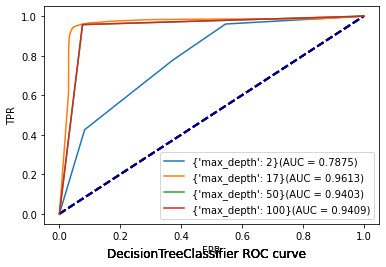

In [85]:
param = {"max_depth": [2, 17, 50, 100]}
treeparam, treeplt = modelEvaluation(DecisionTreeClassifier(), param, [X_train, X_val, y_train, y_val])
treepred = decisiontree.predict(X_val)
treescore = decisiontree.score(X_val, y_val), precision_score(y_val, y_predict_dt), recall_score(y_val, y_predict_dt)

Different values of max depth seems like the optimal choice is around the 10s lower or higher than that the performance
goes down. <br>The best choice is **17** and the worst is **2**

### 3- Random Forest Classifier

#### Model Fitting

In [32]:
randomforest = RandomForestClassifier(n_estimators=100, random_state = 77)
randomforest.fit(X_train, y_train)# Random Forest's score is already high doesn't need any grid search for parameter

RandomForestClassifier(random_state=77)

#### Model Prediction

In [33]:
y_predict_rf = randomforest.predict(X_val)

#### Model Scores

In [34]:
getScores(randomforest, X_train, y_train, X_val, y_val, y_predict_rf)

Training Score  0.9991882744220129
Validation Score  0.963028662123051
Precision: 0.9739,   Recall: 0.9701, f1: 0.9720


**Random forest** is the best one so far with a slight overfit.

#### Model Confuision Matrix 

In [35]:
interactive(lambda threshold: make_confusion_matrix(randomforest, threshold), threshold=(0.0,1.0,0.02)) 

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

### 4- Extra Trees Classifier

#### Model Fitting

In [36]:
et_model = ExtraTreesClassifier(n_estimators=100, random_state=77)
et_model.fit(X_train, y_train)# Extra trees' score is already high doesn't need any grid search for parameter

ExtraTreesClassifier(random_state=77)

#### Model Prediction

In [37]:
y_predict_et = et_model.predict(X_val) 

#### Model Scores

In [38]:
getScores(et_model, X_train, y_train, X_val, y_val, y_predict_et)

Training Score  0.9991974568380534
Validation Score  0.9635888339090655
Precision: 0.9709,   Recall: 0.9742, f1: 0.9725


**Extra trees** performed better than random forest with a slight overfit.

#### Model Confuision Matrix 

In [39]:
interactive(lambda threshold: make_confusion_matrix(et_model, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

### 5- XGB Classifier

#### Model Fitting

In [80]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic',
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        random_state = 77
                       )
eval_set=[(X_train,y_train),(X_val,y_val)]
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='error',
                    early_stopping_rounds=50,
                    verbose=False
                   )

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


#### Model Prediction

In [81]:
y_pred_xgb = gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit)

#### Model Scores

In [82]:
getScores(gbm, X_train, y_train, X_val, y_val, y_pred_xgb)

Training Score  0.9539538565229129
Validation Score  0.9488376435440201
Precision: 0.9787,   Recall: 0.9431, f1: 0.9606


**XGB** performed less than previous models but it handled the overfit much better than the others.

#### Model Confuision Matrix 

In [49]:
interactive(lambda threshold: make_confusion_matrix(gbm, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

### 6- Gaussian Naive Bayes

#### Model Fitting

In [40]:
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

#### Model Prediction

In [41]:
y_pred_nb=nb.predict(X_val)

#### Model Scores

In [42]:
getScores(nb,X_train,y_train,X_val,y_val,y_pred_nb)

Training Score  0.573357403506581
Validation Score  0.5149845952758846
Precision: 0.7460,   Recall: 0.4039, f1: 0.5240


**Gaussian** performed horribly but handled the overfit well.

#### Model Confuision Matrix 

In [43]:
interactive(lambda threshold: make_confusion_matrix(nb, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

### 7- Bernoulli Naive Bayes

#### Model Fitting

In [44]:
br = BernoulliNB()
br.fit(X_train, y_train)

BernoulliNB()

#### Model Prediction

In [45]:
y_pred_br = br.predict(X_val)

#### Model Scores

In [46]:
getScores(br,X_train,y_train,X_val,y_val,y_pred_br)

Training Score  0.5740038455958378
Validation Score  0.6005041546074129
Precision: 0.7161,   Recall: 0.6557, f1: 0.6846


**Bernoulli** performed better than **Gaussian** and handled the overfit better.

#### Model Confuision Matrix 

In [47]:
interactive(lambda threshold: make_confusion_matrix(br, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

|        Model          | Training Accuracy  | Validation Accuracy | F1      | Recall  | Precision  |
|-----------------------|--------------------|---------------------|---------|---------|------------|
| Logistic Regression   | 0.5936         | 0.5391              | 0.5579  | 0.4399  | 0.7625     |
| Decision Tree         | 0.9750         | 0.9492              | 0.9611  | 0.9487  | 0.9738     |
| Random Forest         | 0.9991         | 0.9630              | 0.9720  | 0.9701  | 0.9739     |
| Extra Trees           | 0.9991         | 0.9635              | 0.9725  | 0.9742  | 0.9709     |
| XGB                   | 0.9515         | 0.9457              | 0.9576  | 0.9365  | 0.9796     |
| Gaussian              | 0.5733         | 0.5149              | 0.5240  | 0.4039  | 0.7460     |
| Bernoulli             | 0.5740         | 0.6005              | 0.6846  | 0.6557  | 0.7161     |

## Introducing polynomial feature to each model

In hopes of solving the overfit issue polynomial features will be added to the previous models.

In [48]:
trans = PolynomialFeatures(degree=2) # Second degree
poly_X_train = trans.fit_transform(X_train)
poly_X_val = trans.transform(X_val)

### 8- Polynomial Feature with Logistic Regression

#### Model Fitting

In [49]:
lr_poly = LogisticRegression(C=1, random_state = 77)
lr_poly.fit(poly_X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1, random_state=77)

#### Model Prediction

In [50]:
y_predict_lr_poly = lr_poly.predict(poly_X_val)

#### Model Scores

In [51]:
getScores(lr_poly, poly_X_train, y_train, poly_X_val, y_val, y_predict_lr_poly)

Training Score  0.6557952982356906
Validation Score  0.6252450751563813
Precision: 0.8057,   Recall: 0.5708, f1: 0.6682


### 9- Polynomial Feature with Decision Tree

#### Model Fitting

In [52]:
poly_decisiontree = DecisionTreeClassifier(max_depth=17, random_state = 77)
poly_decisiontree.fit(poly_X_train, y_train)

DecisionTreeClassifier(max_depth=17, random_state=77)

#### Model Prediction

In [53]:
y_predict_decisiontree_poly = poly_decisiontree.predict(poly_X_val)

#### Model Scores

In [54]:
getScores(poly_decisiontree, poly_X_train, y_train, poly_X_val, y_val, y_predict_decisiontree_poly)

Training Score  0.9668900442408804
Validation Score  0.9455699747922697
Precision: 0.9739,   Recall: 0.9429, f1: 0.9582


### 10- Polynomial Feature with Random Forest

#### Model Fitting

In [55]:
poly_randomforest = RandomForestClassifier(n_estimators=100, random_state = 77)
poly_randomforest.fit(poly_X_train, y_train)

RandomForestClassifier(random_state=77)

#### Model Prediction

In [56]:
y_predict_randomforest_poly = poly_randomforest.predict(poly_X_val)

#### Model Scores

In [57]:
getScores(poly_randomforest, poly_X_train, y_train, poly_X_val, y_val, y_predict_randomforest_poly)

Training Score  0.9991901109052209
Validation Score  0.9631220240873868
Precision: 0.9739,   Recall: 0.9702, f1: 0.9721


### 11- Polynomial Feature with Extra Trees

#### Model Fitting

In [58]:
poly_et = ExtraTreesClassifier(n_estimators=100, random_state=77)
poly_et.fit(poly_X_train, y_train)

ExtraTreesClassifier(random_state=77)

#### Model Prediction

In [59]:
y_predict_et_poly = poly_et.predict(poly_X_val)

#### Model Scores

In [60]:
getScores(poly_et, poly_X_train, y_train, poly_X_val, y_val, y_predict_et_poly)

Training Score  0.9991974568380534
Validation Score  0.9633087480160583
Precision: 0.9707,   Recall: 0.9739, f1: 0.9723


### Polynomial features with models summary

|        Model      | Logistic Regresion | Decision Tree | Random Forest | Extra Trees | XGB        |
|-------------------|--------------------|---------------|---------------|-------------|------------|
| Training before   | Tr:0.5936          | Tr:0.9750     | Tr:0.9991     | Tr:0.9991   | Tr:0.9515  |
| Validation before | Val:0.5391         | Val:0.9492    | Val:0.9630    | Val:0.9635  | Val:0.9457 |
| Difference        | 5.45%              | 2.58%         | 3.6%         | 3.56%       | 0.58%      |
| Training after    | Tr:0.6557          | Tr:0.9668     | Tr:0.9991     | Tr:0.9991   |     -      |
| Validation after  | Val:0.6252         | Val:0.9455    | Val:0.9631    | Val:0.9633  |     -      |
| Difference        | 3.05%              | 2.13%         | 3.6%          | 3.58%       | no overfit |

As seen in the table above the logistic regression percentage difference went down but since there are better models in terms of
accuracy scores this model will be neglected. <br> 
Decision tree percenatge difference also went down by 0.004 but its not worth to load up to 78 feature for that amount.<br>
Random forest percenatge difference stayed the same and Extra trees percentage difference went up.<br>
With that said, the polynomial feature attempt will be neglected.

### Compare Models 

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:30:43] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Model: RandomForestClassifier


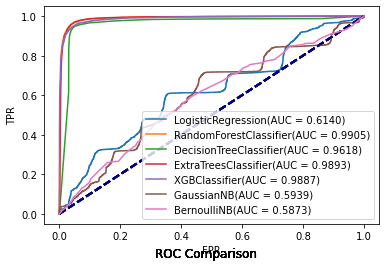

In [83]:
modelComparision([lr, randomforest, decisiontree, et_model, gbm, nb, br], [X_train, X_val, y_train, y_val]);

Best model -> Random Forest<br>
Worst model -> Bernoulli

### Decision boundry for each model

In [102]:
clf1 = LogisticRegression(C=1, random_state = 77)
clf2 = DecisionTreeClassifier(max_depth=17, random_state = 77)
clf3 = RandomForestClassifier(n_estimators=100, random_state = 77)
clf4 = ExtraTreesClassifier(n_estimators=100, random_state=77)
clf5 = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        random_state = 77
                       )
clf6 = GaussianNB()
clf7 = BernoulliNB()

/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:04:44] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


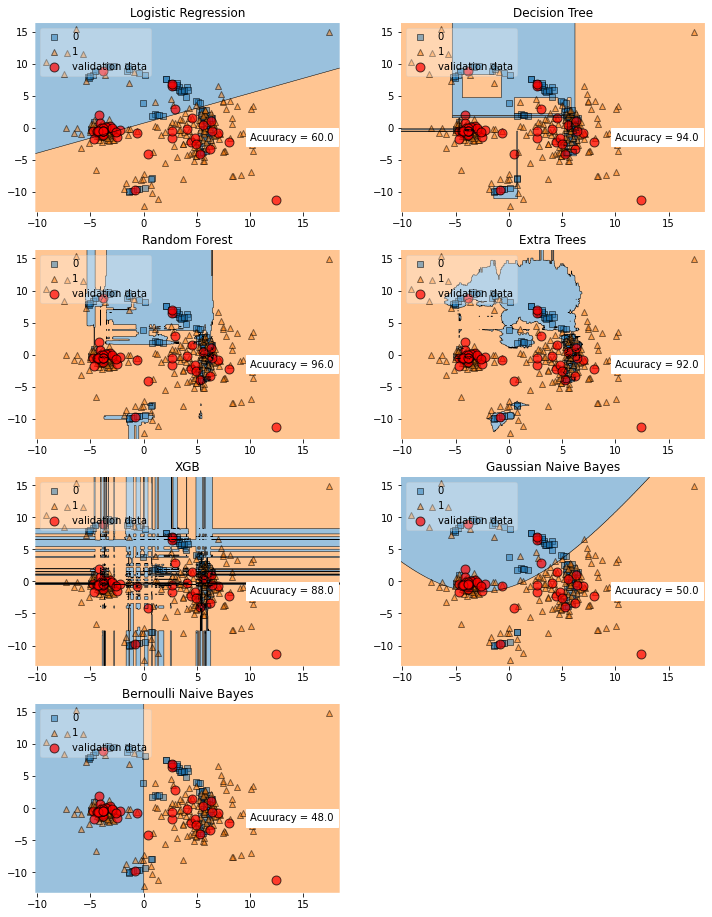

In [116]:
gs = gridspec.GridSpec(4, 2)
fig = plt.figure(figsize=(12,16))
labels = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Extra Trees', 'XGB', 'Gaussian Naive Bayes','Bernoulli Naive Bayes']
X_draw = X_train.sample(500 , random_state = 70)
y_draw = y_train.sample(500 , random_state = 70).astype(int)

pca = PCA(n_components = 2)
X_train2 = pca.fit_transform(X_draw)

X_v = X_val.sample(50 , random_state = 70)
y_v = y_val.sample(50 , random_state = 70).astype(int)
X_v_2 = pca.transform(X_v)
scatter_highlight_kwargs = {'label': 'validation data', 'alpha': 0.7, 'c':'red'}
scatter_kwargs = {'alpha': 0.5 }
for clf, lab, grd in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf7],
                         labels,
                         [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1), (3,0)]):
    ax = plt.subplot(gs[grd[0], grd[1]])
    clf.fit(X_train2, y_draw)
    accuracy = clf.score(X_v_2, y_v) * 100
    fig = plot_decision_regions(X = np.array(X_train2), y = np.array(y_draw), clf = clf, legend=2,
                                scatter_kwargs = scatter_kwargs, X_highlight = np.array(X_v_2), 
                                scatter_highlight_kwargs = scatter_highlight_kwargs)
    plt.text(10,-2,f'Acuuracy = {accuracy}', fontsize = 10, backgroundcolor = 'w', color ='black');
    plt.title(lab)
plt.show()

As its shown in the plot above, the best three models are **Random Forest**, **Decision tree** and **Extra trees** so 
those models will be fitted into voting/stacking classifers

### Introducing the best 3 models into Voting & Stacking classifiers

In [61]:
model_names = ["randomforest", "decisiontree" ,"et_model"]# Best three models
model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

### Voting Classifier

#### Model Fitting

In [62]:
weights = [2,1,2.5]# Assigning weights
voting_model = VotingClassifier(estimators=model_list,
                                    voting='soft', 
                                    weights = weights,  #include weights
                                    n_jobs=-1)
voting_model.fit(X_train, y_train)

VotingClassifier(estimators=[('randomforest',
                              RandomForestClassifier(random_state=77)),
                             ('decisiontree',
                              DecisionTreeClassifier(max_depth=17,
                                                     random_state=77)),
                             ('et_model',
                              ExtraTreesClassifier(random_state=77))],
                 n_jobs=-1, voting='soft', weights=[2, 1, 2.5])

#### Model Prediction

In [63]:
y_pred_v = voting_model.predict(X_val)

#### Model Scores

In [64]:
getScores(voting_model, X_train, y_train, X_val, y_val, y_pred_v)

Training Score  0.9991974568380534
Validation Score  0.9615348706936794
Precision: 0.9726,   Recall: 0.9691, f1: 0.9709


#### Model Confuision Matrix 

In [65]:
interactive(lambda threshold: make_confusion_matrix(voting_model, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

### Stacking Classifier

#### Model Fitting

In [66]:
stacked = StackingClassifier(
    classifiers=model_vars, meta_classifier=RandomForestClassifier(n_estimators=100), use_probas=False)
stacked.fit(X_train, y_train)

StackingClassifier(classifiers=[RandomForestClassifier(random_state=77),
                                DecisionTreeClassifier(max_depth=17,
                                                       random_state=77),
                                ExtraTreesClassifier(random_state=77)],
                   meta_classifier=RandomForestClassifier())

#### Model Prediction

In [67]:
y_pred_s = stacked.predict(X_val)

#### Model Scores

In [68]:
getScores(stacked,X_train, y_train, X_val, y_val, y_pred_s)

Training Score  0.9991974568380534
Validation Score  0.9632153860517225
Precision: 0.9697,   Recall: 0.9749, f1: 0.9723


#### Model Confuision Matrix 

In [69]:
interactive(lambda threshold: make_confusion_matrix(stacked, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

Stacked classifer will be chosen for further enhancement.

|        Model          | Training Accuracy  | Validation Accuracy | F1      | Recall  | Precision  |
|-----------------------|--------------------|---------------------|---------|---------|------------|
| Voting                | 0.9991         | 0.9615              | 0.9709  | 0.9691  | 0.9726     |
| Stacking              | 0.9991         | 0.9632              | 0.9723  | 0.9749  | 0.9697     |

## Feature Engineering

In [71]:
corr = all_data.corr()

In [72]:
corr

,x,y,z,Activity_Class,lgwatch,nexus4,s3,s3mini,samsungold,phone_gyro,watch_acc,watch_gyro
x,1.000000,-0.012014,-0.203706,-0.187521,0.018866,-0.042663,-0.001568,0.031680,-0.040224,0.153859,0.014973,0.059488
y,-0.012014,1.000000,0.070740,0.002342,-0.252605,0.088405,0.092604,0.064411,0.034979,0.082935,-0.398578,0.033772
z,-0.203706,0.070740,1.000000,-0.000107,-0.252919,0.148337,-0.111716,0.038331,0.308788,-0.673995,-0.115735,-0.257009
Activity_Class,-0.187521,0.002342,-0.000107,1.000000,0.022767,-0.020474,-0.021057,-0.009393,0.025347,-0.025774,0.034961,0.017410
lgwatch,0.018866,-0.252605,-0.252919,0.022767,1.000000,-0.350396,-0.276278,-0.149795,-0.121139,-0.384539,0.634612,0.593494
nexus4,-0.042663,0.088405,0.148337,-0.020474,-0.350396,1.000000,-0.465408,-0.252339,-0.204066,0.133414,-0.260917,-0.247027
s3,-0.001568,0.092604,-0.111716,-0.021057,-0.276278,-0.465408,1.000000,-0.198963,-0.160901,0.316728,-0.205727,-0.194774
s3mini,0.031680,0.064411,0.038331,-0.009393,-0.149795,-0.252339,-0.198963,1.000000,-0.087239,0.057133,-0.111543,-0.105605
samsungold,-0.040224,0.034979,0.308788,0.025347,-0.121139,-0.204066,-0.160901,-0.087239,1.000000,-0.223951,-0.090204,-0.085402
phone_gyro,0.153859,0.082935,-0.673995,-0.025774,-0.384539,0.133414,0.316728,0.057133,-0.223951,1.000000,-0.286342,-0.271098


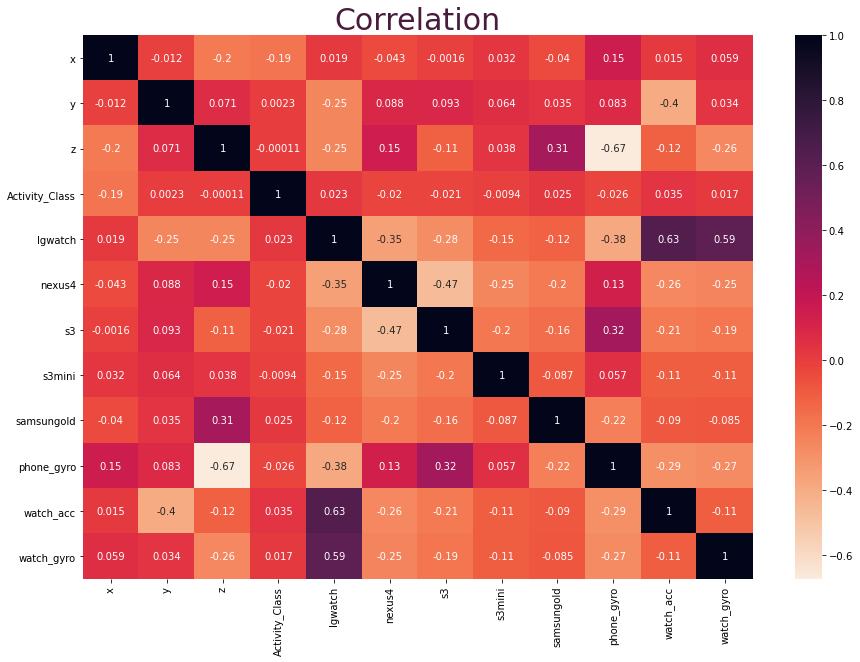

In [73]:
plt.figure(figsize = [15,10])
sns.heatmap(corr, annot = True, cmap = sns.cm.rocket_r );
plt.title('Correlation', color= '#481D3B', fontsize=30);

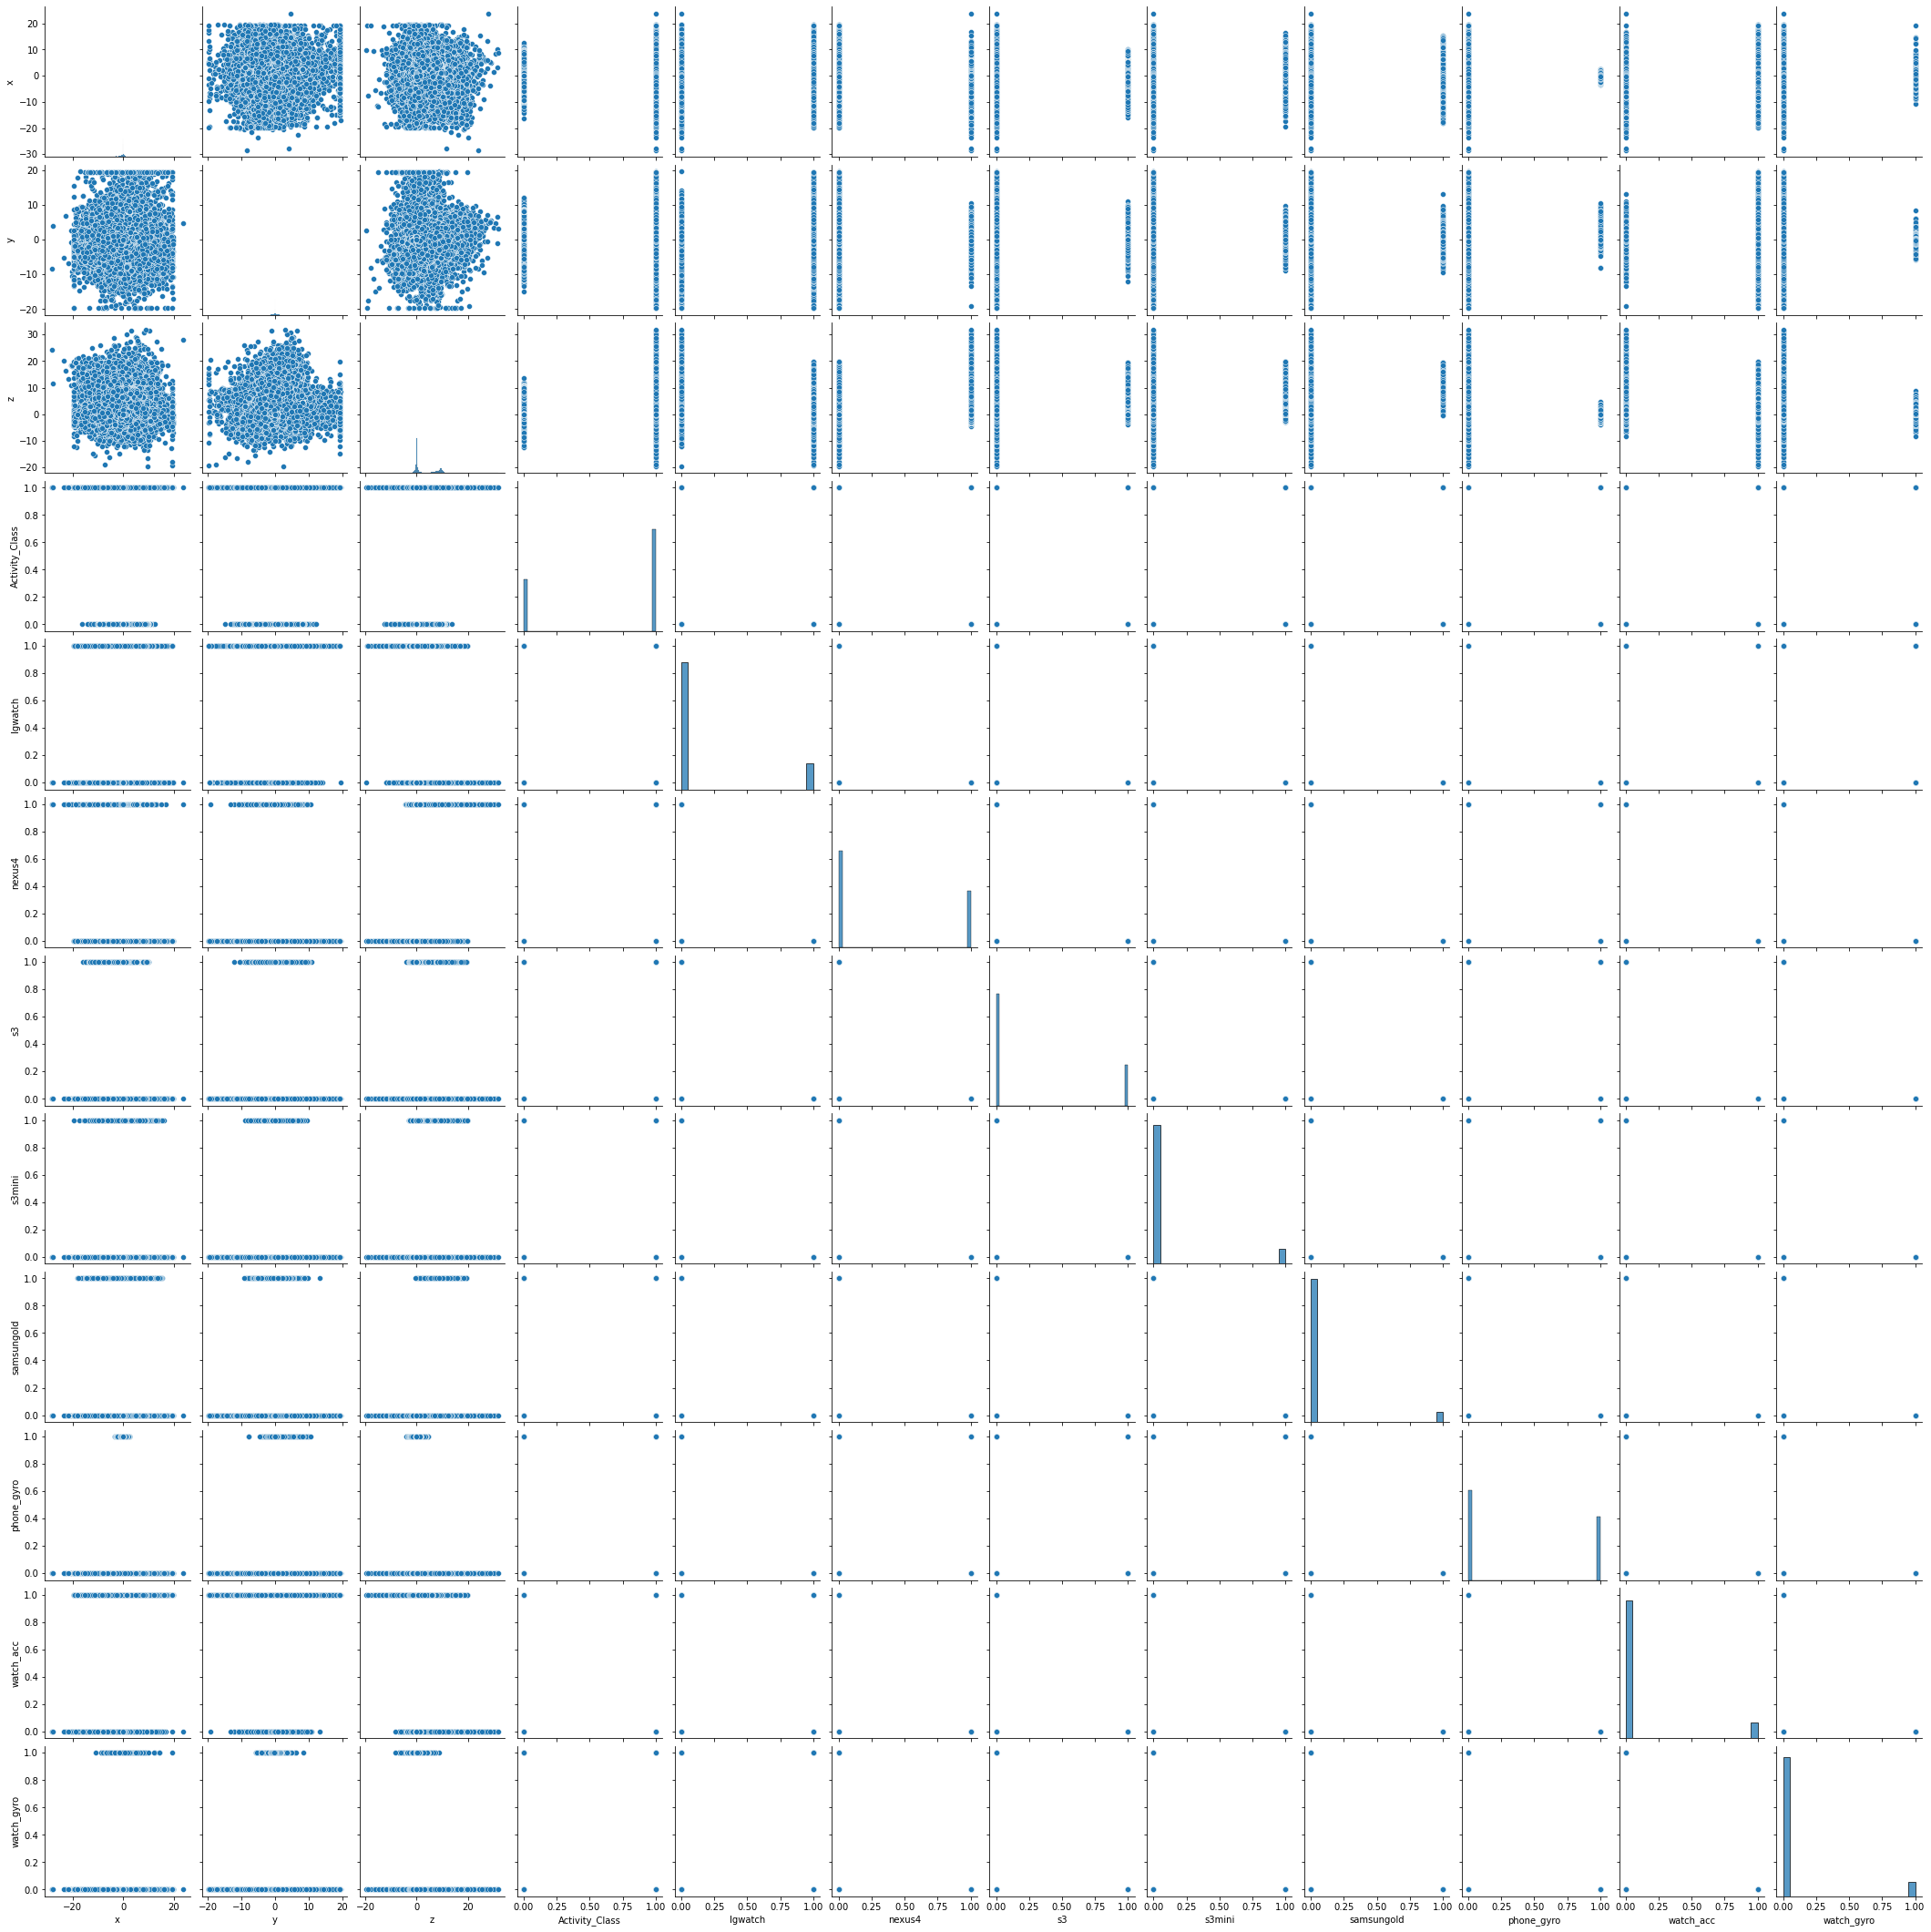

In [74]:
sns.pairplot(all_data);

### Model before any feature engineering

Training Score  0.9991974568380534<br>
Validation Score  0.9632153860517225<br>
Precision: 0.9697<br>   Recall: 0.9749<br> f1: 0.9723

### Attempt 1

As shown in the heatmap above there is a colinearity between __lgwatch__ and both __watch_acc__ and __watch_gyro__ so, first attepmt will be trying to drop __lgwatch__ column and see what will happen.

In [70]:
X_train_i1 = X_train.copy()
X_val_i1 = X_val.copy()

X_train_i1.drop('lgwatch', axis = 1, inplace = True)
X_val_i1.drop('lgwatch', axis = 1, inplace = True)

get_new_scores(X_train_i1, y_train, X_val_i1, y_val)

Training Score  0.9991974568380534
Validation Score  0.963402109980394
Precision: 0.9707,   Recall: 0.9740, f1: 0.9724


As shown, there is __+0.0002__ affect on accuracy when trying to drop __lgwatch__ that means it has a positive change.<br>
This attempt is approved.

In [71]:
X_train = X_train_i1.copy()
X_val = X_val_i1.copy()

X_test.drop('lgwatch', axis = 1, inplace = True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Attempt 2

As shown in the heatmap above there is a colinearity between __phone_gyro__ and __z__ so, this attepmt will be trying to drop __phone_gyro__ column and see what will happen.

In [72]:
X_train_i2 = X_train.copy()
X_val_i2 = X_val.copy()

X_train_i2.drop('phone_gyro', axis = 1, inplace = True)
X_val_i2.drop('phone_gyro', axis = 1, inplace = True)

get_new_scores(X_train_i2, y_train, X_val_i2, y_val)

Training Score  0.9991974568380534
Validation Score  0.963028662123051
Precision: 0.9693,   Recall: 0.9750, f1: 0.9721


As shown, there is __-0.0004__ affect on accuracy when trying to drop __lgwatch__ that means this attempt failed.

### Attempt 3

we will try to normalise __z__ column and see what will happen

In [73]:
X_train_i3 = X_train.copy()
X_val_i3 = X_val.copy()

pt = PowerTransformer()
X_train_i3['z_trans'] = pt.fit_transform(np.array(X_train_i3['z']).reshape(-1, 1))
X_val_i3['z_trans'] = pt.fit_transform(np.array(X_val_i3['z']).reshape(-1, 1))

get_new_scores(X_train_i3, y_train, X_val_i3, y_val)

Training Score  0.9991974568380534
Validation Score  0.9582672019419288
Precision: 0.9628,   Recall: 0.9746, f1: 0.9686


As shown, there is __- 0.01__ affect on accuracy when we trying to normalise __z__ column that means attempt 3 failed.

### Attempt 4

we will try to normalise __y__ column and see what will happen

In [74]:
X_train_i4 = X_train.copy()
X_val_i4 = X_val.copy()

pt = PowerTransformer()
X_train_i4['y_trans'] = pt.fit_transform(np.array(X_train_i4['y']).reshape(-1, 1))
X_val_i4['y_trans'] = pt.fit_transform(np.array(X_val_i4['y']).reshape(-1, 1))

get_new_scores(X_train_i4, y_train, X_val_i4, y_val)

Training Score  0.9991974568380534
Validation Score  0.9609746989076651
Precision: 0.9663,   Recall: 0.9750, f1: 0.9706


As shown, there is __- 0.003__ affect on accuracy when the column __y__ was normalized that means attempt 4 failed.

### Attempt 5

we will try to normalise __x__ column and see what will happen

In [75]:
X_train_i5 = X_train.copy()
X_val_i5 = X_val.copy()

pt = PowerTransformer()
X_train_i5['x_trans'] = pt.fit_transform(np.array(X_train_i5['x']).reshape(-1, 1))
X_val_i5['x_trans'] = pt.fit_transform(np.array(X_val_i5['x']).reshape(-1, 1))

get_new_scores(X_train_i5, y_train, X_val_i5, y_val)

Training Score  0.9991974568380534
Validation Score  0.821491924190085
Precision: 0.7952,   Recall: 0.9832, f1: 0.8793


As shown, there is __- 0.1__ affect on accuracy when we trying to normalise x column that mean attempt 5 failed.

### Feature Engineering Summary 

|        ORIGINAL      | Train: 0.9991      | Validation: 0.9632| STATUS |
|----------------------|--------------------|-------------------|--------|
| Attemp 1             | Train: 0.9991      | Validation: 0.9634|Approved|
| Attemp 2             | Train: 0.9991      | Validation: 0.9630|Failed  |
| Attemp 3             | Train: 0.9991      | Validation: 0.9582|Failed  |
| Attemp 4             | Train: 0.9991      | Validation: 0.9606|Failed  |
| Attemp 5             | Train: 0.9991      | Validation: 0.8214|Failed  |


### Store Data After Changes into database

In [76]:
# save our sets to database
X_train_conn = sql.connect('Data/X_train_after_FE.db')
X_train.to_sql('X_train_after_FE', X_train_conn)

X_val_conn = sql.connect('Data/X_val_after_FE.db')
X_val.to_sql('X_val_after_FE', X_val_conn)

X_test_conn = sql.connect('Data/X_test_after_FE.db')
X_test.to_sql('X_test_after_FE', X_test_conn)

y_train_conn = sql.connect('Data/y_train_after_FE.db')
y_train.to_sql('y_train_after_FE', y_train_conn)

y_val_conn = sql.connect('Data/y_val_after_FE.db')
y_val.to_sql('y_val_after_FE', y_val_conn)

y_test_conn = sql.connect('Data/y_test_after_FE.db')
y_test.to_sql('y_test_after_FE', y_test_conn)